In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [2]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import cv2

In [3]:
import torch
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

from object_detection_fastai.helper.wsi_loader import *

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [4]:
from object_detection_fastai.helper.BoundingBox import BoundingBox
from object_detection_fastai.helper.BoundingBoxes import BoundingBoxes
from object_detection_fastai.helper.Evaluator import *
from object_detection_fastai.helper.utils import *

In [5]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [6]:
class SlideContainerWithY(SlideContainer):

    def get_patch_y(self,  x: int=0, y: int=0):

        bboxes, labels = self.y

        bboxes = np.array([box for box in bboxes]) if len(np.array(bboxes).shape) == 1 else  np.array(bboxes)
        labels = np.array(labels)

        if len(labels) > 0:
            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - x
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - y

            bb_widths = (bboxes[:, 2] - bboxes[:, 0]) / 2
            bb_heights = (bboxes[:, 3] - bboxes[:, 1]) / 2

            ids = ((bboxes[:, 0] + bb_widths) > 0) \
                      & ((bboxes[:, 1] + bb_heights) > 0) \
                      & ((bboxes[:, 2] - bb_widths) < self.width) \
                      & ((bboxes[:, 3] - bb_heights) < self.height)

            bboxes = bboxes[ids]
            bboxes = np.clip(bboxes, 0, max(self.height,self.width))
            #bboxes = bboxes[:, [1, 0, 3, 2]]

            labels = labels[ids]
        
        if len(labels) == 0:
            labels = np.array([0])
            bboxes = np.array([[0, 0, 1, 1]])

        return [bboxes, labels]

In [7]:

class WSIDataset(Dataset):
    
    def __init__(self, dataframe: list, label_id_lookup:dict, transforms=None):
        super().__init__()

        self.image_ids = range(len(dataframe))
        self.items = dataframe
        self.transforms = transforms
        self.label_id_lookup = label_id_lookup

    def __getitem__(self, index: int):

        slide_container = self.items[index]

        xmin, ymin = slide_container.get_new_train_coordinates()
        image = slide_container.get_patch(x=xmin, y=ymin) / 255.0

        bboxes, labels = slide_container.get_patch_y(x=xmin, y=ymin)
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor([self.label_id_lookup[i] for i in labels], dtype=torch.int64)
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)


        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0).float()

        return image, target, index


    def __len__(self) -> int:
        return len(self.items)

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
slides_train = list(set(['BAL Promyk Spray 4.svs',
                         'BAL AIA Blickfang Luft.svs']))

slides_val = list(set(['BAL 1 Spray 2.svs', 
                         'BAL Booker Spray 3.svs',
                         'BAL Bubi Spray 1.svs', 
                         'BAL cent blue Luft 2.svs']))

experiment_name = "Asthma-L0"
class_labels = ['Lymohozyten']
label_id_lookup = {label:id+1 for id, label in enumerate(class_labels)}
id_label_lookup = {id+1:label for id, label in enumerate(class_labels)}

In [10]:
annotations_path = Path("../../Statistics/Asthma_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)

annotations = annotations[annotations["class"].isin(class_labels)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_val.head()

,id,image_id,image_name,image_set,class,vector,unique_identifier,user_id,deleted,last_editor
3081,172293,221,BAL 1 Spray 2.svs,14,Lymohozyten,"{'x1': 13659, 'x2': 13695, 'y1': 12058, 'y2': ...",351a23d8-4939-491c-af33-d71255d1fba0,10,False,None
3082,172294,221,BAL 1 Spray 2.svs,14,Lymohozyten,"{'x1': 13632, 'x2': 13670, 'y1': 12070, 'y2': ...",0768816b-7335-4129-bdc5-85abdfbe19f2,10,False,None
3083,172295,221,BAL 1 Spray 2.svs,14,Lymohozyten,"{'x1': 13581, 'x2': 13623, 'y1': 12084, 'y2': ...",46e1fdae-eb8a-40f5-a050-94ff5aa8d7d9,10,False,None
3084,172296,221,BAL 1 Spray 2.svs,14,Lymohozyten,"{'x1': 13536, 'x2': 13578, 'y1': 12008, 'y2': ...",bcbfc85a-6ee4-4303-a824-b7e2fddce5ad,10,False,None
3085,172297,221,BAL 1 Spray 2.svs,14,Lymohozyten,"{'x1': 13589, 'x2': 13629, 'y1': 12135, 'y2': ...",090abe2d-9980-4c03-b949-81c4cb1eacdb,10,False,None


In [11]:
annotations_train

,id,image_id,image_name,image_set,class,vector,unique_identifier,user_id,deleted,last_editor
25039,140900,226,BAL Promyk Spray 4.svs,14,Lymohozyten,"{'x1': 13991, 'x2': 14037, 'y1': 14520, 'y2': ...",9d552252-4980-4b09-bf78-2b7c906d41ad,10,False,None
25040,140901,226,BAL Promyk Spray 4.svs,14,Lymohozyten,"{'x1': 13940, 'x2': 13990, 'y1': 14521, 'y2': ...",e401f70c-df1e-4f50-8d78-3a07ed5c3cbe,10,False,None
25041,140902,226,BAL Promyk Spray 4.svs,14,Lymohozyten,"{'x1': 14240, 'x2': 14294, 'y1': 14441, 'y2': ...",07b795f2-a483-4191-bb32-db8f7e750234,10,False,None
25042,140903,226,BAL Promyk Spray 4.svs,14,Lymohozyten,"{'x1': 14446, 'x2': 14496, 'y1': 14406, 'y2': ...",4ead2c3a-a581-435d-99c3-bab31998ffee,10,False,None
25043,140904,226,BAL Promyk Spray 4.svs,14,Lymohozyten,"{'x1': 14496, 'x2': 14546, 'y1': 14320, 'y2': ...",d149774f-cfa4-458d-9c13-1695361ef09f,10,False,None
...,...,...,...,...,...,...,...,...,...,...
73107,130337,222,BAL AIA Blickfang Luft.svs,14,Lymohozyten,"{'x1': 21812, 'x2': 21874, 'y1': 6365, 'y2': 6...",78411938-ad1b-46bd-bdce-a16fa9f9d603,10,False,None
73108,130338,222,BAL AIA Blickfang Luft.svs,14,Lymohozyten,"{'x1': 21845, 'x2': 21909, 'y1': 6364, 'y2': 6...",ae3a8031-9647-43f1-b13f-03c280cad29a,10,False,None
73109,130339,222,BAL AIA Blickfang Luft.svs,14,Lymohozyten,"{'x1': 21881, 'x2': 21945, 'y1': 6362, 'y2': 6...",70a4aca9-4bab-40e9-ba47-0c557f171556,10,False,None
73110,130340,222,BAL AIA Blickfang Luft.svs,14,Lymohozyten,"{'x1': 22303, 'x2': 22379, 'y1': 5785, 'y2': 5...",9db92129-9648-4072-968e-37922dea39ae,10,False,None


In [12]:
slides_path = Path("../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs") if slide.name in slides_train + slides_val}

size = 1024 
level = 0
bs = 8
train_images = 500
val_images = 500

In [13]:
train_files = []
val_files = []

for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)

    train_files.append(SlideContainerWithY(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)

    val_files.append(SlideContainerWithY(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))

train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_dataset = WSIDataset(train_files, label_id_lookup, get_train_transform())
valid_dataset = WSIDataset(valid_files, label_id_lookup, get_valid_transform())

In [16]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


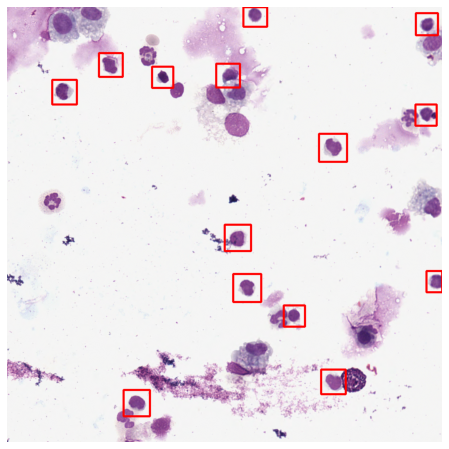

In [18]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()


fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [19]:
backbone = list(torchvision.models.resnet18(pretrained=True).children())[:-2]
backbone = nn.Sequential(*backbone)
backbone.out_channels = 512

In [20]:
anchor_generator = AnchorGenerator(sizes=((30, 40, 50, 60, 70),), aspect_ratios=((1.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1"],output_size=7,sampling_ratio=2)

In [21]:
model = FasterRCNN(backbone,
                   num_classes=len(labels)+1,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

In [23]:
loss_hist = Averager()
itr = 1
num_epochs = 30
metrics = []

for epoch in range(num_epochs):
    loss_hist.reset()
    
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device, dtype=torch.float) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()


    model.eval()

    evaluator = Evaluator()
    boundingBoxes = BoundingBoxes()
    cpu_device = torch.device("cpu")
    ap = 'AP'
    for images, targets, image_ids in valid_data_loader:
        
        images = list(image.to(device, dtype=torch.float) for image in images)
        targets = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs  = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):

            for box, cla in zip(np.array(target["boxes"]), np.array(target["labels"])):
                temp = BoundingBox(imageName=str(int(targets[0]["image_id"])), classId=id_label_lookup[cla], x=box[0], y=box[1],
                               w=box[2], h=box[3], typeCoordinates=CoordinatesType.Absolute,
                               bbType=BBType.GroundTruth, format=BBFormat.XYX2Y2, imgSize=(size,size))

                boundingBoxes.addBoundingBox(temp)


            for box, cla, scor in zip(np.array(output["boxes"].detach()), np.array(output["labels"].detach()), np.array(output["scores"].detach())):
                temp = BoundingBox(imageName=str(int(targets[0]["image_id"])), classId=id_label_lookup[cla], x=box[0], y=box[1],
                                   w=box[2], h=box[3], typeCoordinates=CoordinatesType.Absolute, classConfidence=scor,
                                   bbType=BBType.Detected, format=BBFormat.XYX2Y2, imgSize=(size, size))

                boundingBoxes.addBoundingBox(temp)

    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingBoxes, IOUThreshold=0.3)
    metric = {"epoch": epoch,
              "loss": loss_value,
              "sum": max(sum([mc[ap] for mc in metricsPerClass]) / len(metricsPerClass), 0)}

    for mc in metricsPerClass:
        metric['{}-{}'.format(ap, mc['class'])] = max(mc[ap], 0)

    metrics.append(metric)
    print(f"Epoch #{epoch} metrics: {metric}")

d:\anaconda3\envs\eiph_wsi\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch #0 metrics: {'epoch': 0, 'loss': 2.361119031906128, 'sum': 0.0, 'AP-Lymohozyten': 0}
Epoch #1 metrics: {'epoch': 1, 'loss': 1.2736966609954834, 'sum': 0.25315901946230146, 'AP-Lymohozyten': 0.25315901946230146}
Epoch #2 metrics: {'epoch': 2, 'loss': 0.7487327456474304, 'sum': 0.29883474663050474, 'AP-Lymohozyten': 0.29883474663050474}
Epoch #3 metrics: {'epoch': 3, 'loss': 0.67601078748703, 'sum': 0.3159134022371071, 'AP-Lymohozyten': 0.3159134022371071}
Epoch #4 metrics: {'epoch': 4, 'loss': 0.5777313113212585, 'sum': 0.33957008093035324, 'AP-Lymohozyten': 0.33957008093035324}
Epoch #5 metrics: {'epoch': 5, 'loss': 0.6775956749916077, 'sum': 0.3555971978905004, 'AP-Lymohozyten': 0.3555971978905004}
Epoch #6 metrics: {'epoch': 6, 'loss': 0.5118035078048706, 'sum': 0.37397037476300443, 'AP-Lymohozyten': 0.37397037476300443}
Epoch #7 metrics: {'epoch': 7, 'loss': 0.4828134775161743, 'sum': 0.38323645235599707, 'AP-Lymohozyten': 0.38323645235599707}
Epoch #8 metrics: {'epoch': 8, 'l

KeyboardInterrupt: 

In [ ]:
df = []
columns = []

for row in metrics:
    
    df.append(list(row.values()))
    columns = list(row.keys())
    
df = pd.DataFrame(df, columns=columns)   
df